In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import scipy.stats as st
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import glob


In [2]:
run ../util/setupConsole

In [3]:
# dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
# dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'

dirAgData = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'
dirEra5 = '/dartfs-hpc/rc/lab/C/CMIG/ERA5'

years = [1979, 2019]

In [4]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
era5_mx2t_quantiles = xr.open_dataset('era5_mx2t_quantiles.nc')
era5_mx2t_quantiles.load()

era5_mn2t_quantiles = xr.open_dataset('era5_mn2t_quantiles.nc')
era5_mn2t_quantiles.load()

lat = era5_mx2t_quantiles.latitude.values
lon = era5_mx2t_quantiles.longitude.values

In [6]:
with open('growing_season_len_maize.dat', 'rb') as f:
    growing_season_len = pickle.load(f)

heatwave_days = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1980, 2018+1)), 6], np.nan)
coldwave_days = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1980, 2018+1)), 6], np.nan)
for y, year in enumerate(range(1980, 2018+1)):
    with open('heat_wave_days/era5_heat_wave_days_%d.dat'%year, 'rb') as f:
        cur_heatwave_days = pickle.load(f)
        heatwave_days[:, :, y, :] = cur_heatwave_days[:, :, :]
    with open('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'rb') as f:
        cur_coldwave_days = pickle.load(f)
        coldwave_days[:, :, y, :] = cur_coldwave_days[:, :, :]

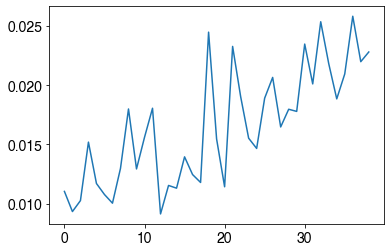

In [7]:
hw = np.array([heatwave_days[:,:,y,5]/growing_season_len for y in range(heatwave_days.shape[2])])
plt.plot(np.nanmean(np.nanmean(hw, axis=2), axis=1))

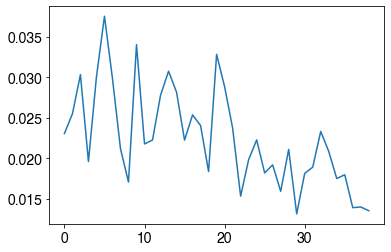

In [8]:
cw = np.array([coldwave_days[:,:,y,2]/growing_season_len for y in range(coldwave_days.shape[2])])
plt.plot(np.nanmean(np.nanmean(cw, axis=2), axis=1))

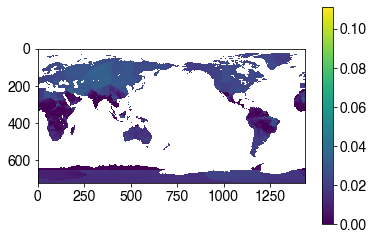

In [26]:
plt.imshow(np.nanmean(hw_frac, axis=0)); plt.colorbar()

In [24]:
hw_frac.shape

(39, 721, 1440)

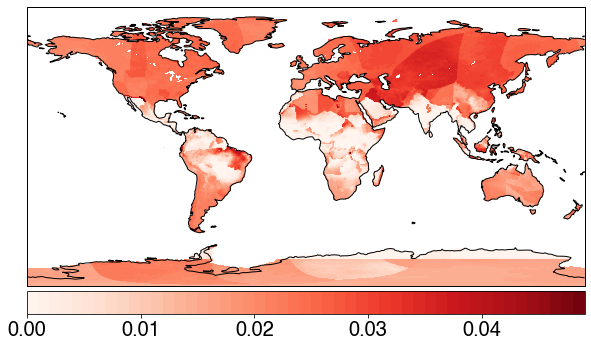

In [9]:
hw_frac = np.array([heatwave_days[:,:,y,5]/growing_season_len for y in range(heatwave_days.shape[2])])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-128, -67, 23, 46])

v1 = 0
v2 = .05
vstep = .001
vlabelstep = .01

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')
c = plt.contourf(lon, lat, np.nanmean(hw_frac, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
ax.coastlines()
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

In [41]:
lat = era5_mx2t_quantiles.latitude.values
lon = era5_mx2t_quantiles.longitude.values

In [48]:
# regrid sacks data

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)

Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [5]:
# calc era5 quantiles

dsMin = xr.open_mfdataset('%s/daily/tasmin_*.nc'%dirEra5)
dsMin['mn2t'] -= 273.15
dsMin_quantile = dsMin.chunk({'latitude':200, 'longitude':200, 'time': -1}).quantile(q=[.01, .05, .1, .9, .95, .99], dim='time')
dsMin_quantile.mn2t.to_netcdf('era5_mn2t_quantiles.nc')